In [1]:
from ilqr.envs import PointMass, Arm
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
import ipdb
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility function

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [110]:
def iLQR(env, iterations=100, 
         reg = 1,                  # initial regularization
         reg_lims = (1e-6, 1e10),  # limtis on regularization
         dreg = 2,                 # reg is multiplied or divided by dreg
         dreg_factor = 1.6,        # dreg is multiplied or diveded by dreg_factor):
         alpha = 1,
         verbose = False,
        ):        

    """
    todo:
    - line search for alpha parameter
    - convergence check
    - control limits (box QP)
    
    fixes:
    - moidfy matrix inversion
    - simpler V updates
    - divergence check
    - add control cost
    - add alpha
    - add reg to V_xx, not Q_xx
    """

    # initial trajectory
    actions = [(0,0) for i in range(env.max_steps)]
    states, costs, costs_derivs = env.rollout(actions)
    state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
    V_x  = costs_derivs[-1]['l_x']
    V_xx = costs_derivs[-1]['l_xx']
    history = dict(cost=[sum(costs)], reg=[reg])
    
    if verbose:
        headers = '{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}{:12.12}'.format(
            'iteration', 'cost', 'dcost', 'expected', 'reg', 'status', 'max_action')
        print(headers, '\n' + ''.join(['-']*len(headers)))

    for i in tqdm(range(iterations)) if not verbose else range(iterations):
        
        # backward pass
        # (compute new control rules k and K)
        complete = False
        while not complete:
            k, K = [], []
            dV = 0
            
            for t in range(env.max_steps-1, -1, -1):
                l, f = costs_derivs[t], state_derivs[t]    

                Q_x  = l['l_x']  + f['f_x'].T @ V_x
                Q_u  = l['l_u']  + f['f_u'].T @ V_x
                Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']  # why not regularized in tod code?
                Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
                Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']

                # compute controls k and K
                Q_uu_reg = Q_uu + np.diag([reg]*len(Q_u))
                
                try:
                    # cholesky decomposition for matrix inverse
                    L = np.linalg.cholesky(Q_uu_reg)
                    k.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_u)))
                    K.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_ux)))
                except np.linalg.LinAlgError:
                    # increase regularization
                    dreg = max(dreg_factor, dreg_factor*dreg)
                    reg = max(reg*dreg, reg_lims[0])
                    complete = False
                    break
                    
                # update V
                dV  +=   alpha**2*.5 * k[-1].T @ Q_uu @ k[-1] + alpha*k[-1].T @ Q_u  # expected cost reduction
                V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
                V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]
                V_xx = .5 * (V_xx + V_xx.T)  # make sure perfectely symmetric by averaging off-diagonals
                complete = True
        
        k.reverse()
        K.reverse()
        
        # forward pass
        # (compute new trajectory with new control law)
        states_new, costs_new, actions_new = [], [], []
        states_new.append(env.reset(reset_target=False))

        for t in range(env.max_steps):
            action_new = actions[t] + alpha*k[t] + K[t] @ (states_new[-1] - states[t])
            actions_new.append(action_new)
            costs_new.append(env.cost(states_new[-1], actions_new[-1])[0])
            states_new.append(env.step(actions_new[-1]))
        
        history['cost'].append(sum(costs_new))

        # regularization update
        delta_cost = sum(costs_new) - sum(costs)

        # increase regularization
        if delta_cost>=0:
            dreg = max(dreg_factor, dreg_factor*dreg)
            reg = max(reg*dreg, reg_lims[0])
            flag = 'increased'

        # decrease regularization
        else:
            dreg = min(1/dreg_factor, dreg/dreg_factor)
            reg *= dreg * (reg > reg_lims[0])  # latter term sets reg=0 if reg<=reg_lims[0]

            actions = actions_new.copy()
            states = states_new.copy()
            costs = costs_new.copy()
            flag = 'decreased'
                
            history['reg'].append(reg)
        
        if verbose:
            print('{:6d}/{:<5d}{:<12.6f}{:<12.2e}{:<12.2e}{:<12.2e}{:<12s}{:<12.6f}'.format(
                i, iterations, history['cost'][-1], delta_cost, dV, reg, flag, np.abs(np.array(actions)).max()))
    
    return actions, history

# two link arm

In [ ]:
# run ilqr
env = Arm(initial_state=[0,0,0,0])
env.target = np.random.uniform([-.2,-.2], [.2,.2])
actions, history = iLQR(env, iterations=20, reg=1, alpha=1e-1, verbose=True, reg_lims=(1e-6, 1e10))

ax = plt.subplots(1, 3, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');
ax[2].imshow(env.render());

iteration   cost        dcost       expected    reg         status      max_action   
------------------------------------------------------------------------------------
     0/20   4.438516    -1.39e-01   -1.08e-01   6.25e-01    decreased   0.010364    
     1/20   4.219932    -2.19e-01   -4.54e-01   2.44e-01    decreased   0.027125    
     2/20   3.914884    -3.05e-01   -5.78e-01   5.96e-02    decreased   0.054034    
     3/20   3.483458    -4.31e-01   -5.69e-01   9.09e-03    decreased   0.107840    
     4/20   2.934815    -5.49e-01   -5.67e-01   8.67e-04    decreased   0.239216    
     5/20   2.384845    -5.50e-01   -7.12e-01   5.17e-05    decreased   0.541194    
     6/20   1.928855    -4.56e-01   -8.49e-01   1.93e-06    decreased   0.938975    


In [ ]:
# show video
env.reset(reset_target=False)
imgs = [env.render()]
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))


In [ ]:
sig = lambda x: (1 / (1 + np.exp(-2*x))) * 2 - 1  # squash between 0 and 1
sig(np.array(actions[0]))

# point mass

iteration   cost        dcost       expected    reg         status       
------------------------------------------------------------------------
     0/20   0.996486    -2.02e+00   -2.02e+00   6.25e-03    decreased   
     1/20   2.845641    1.85e+00    -2.97e+00   1.00e-02    increased   
     2/20   2.844632    1.85e+00    -2.99e+00   2.56e-02    increased   
     3/20   2.841989    1.85e+00    -2.99e+00   1.05e-01    increased   
     4/20   2.828266    1.83e+00    -2.99e+00   6.87e-01    increased   
     5/20   2.720351    1.72e+00    -2.97e+00   7.21e+00    increased   
     6/20   1.995147    9.99e-01    -2.74e+00   1.21e+02    increased   
     7/20   1.173718    1.77e-01    -2.03e+00   3.25e+03    increased   
     8/20   1.000114    3.63e-03    -7.27e-01   1.39e+05    increased   
     9/20   0.996445    -4.10e-05   -1.24e-01   8.71e+04    decreased   
    10/20   0.996543    9.83e-05    -7.80e-01   1.39e+05    increased   
    11/20   0.996527    8.21e-05    -1.17e+00   3.

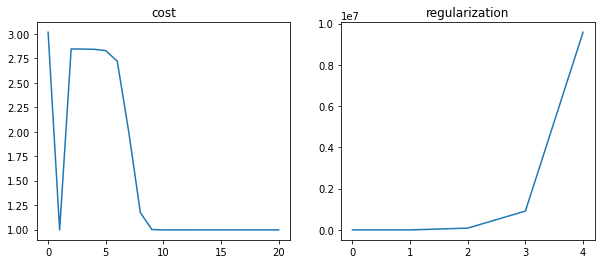

In [25]:
# run ilqr
env = PointMass(max_time=5)
actions, history = iLQR(env, iterations=20, reg=1e-2, verbose=True)
ax = plt.subplots(1,2, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');

In [26]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))